In [1]:
#https://www.nzta.govt.nz/planning-and-investment/learning-and-resources/transport-data/data-and-tools/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

<h3>Cycleways data preparation</h3>

In [5]:
#read cycleways excel data file

url_git = 'https://github.com/phtevegibson/data-projects/blob/main/datasets/PSCycleways.xlsx?raw=true'

df_cycleways = pd.read_excel(url_git,sheet_name=1,header=0,engine='openpyxl')

#Measure column contains only 1 unique value (kms), therefore drop this column to simplify
df_cycleways=df_cycleways.drop(columns=['Measure'])

#Melt column year columns to make df narrow and deep
df_cycleways=df_cycleways.melt(id_vars=['Region/Authority','Region/Authority Type'])

#Rename columns to make them more user-friendly
df_cycleways=df_cycleways.rename(columns={"Region/Authority": "Area", "Region/Authority Type": "Type",
                                          "variable": "Year", "value": "Cycleways(km)"})

df_cycleways.head()

,Area,Type,Year,Cycleways(km)
0,New Zealand,National,2010/11,1148.75
1,Auckland,Regional,2010/11,111.80
2,Bay of Plenty,Regional,2010/11,14.40
3,Canterbury,Regional,2010/11,377.80
4,Gisborne,Regional,2010/11,15.30


(0.0, 3390.0275)

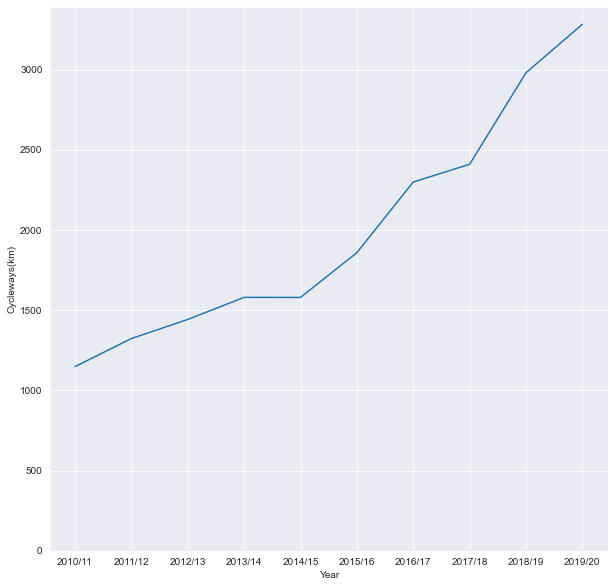

In [6]:
#Total length of cycleways in New Zealand
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(font_scale=1.2)
sns.lineplot(data=df_cycleways.query("Area=='New Zealand'"), x="Year", y="Cycleways(km)")
plt.ylim(0)

In [7]:
df_cycleways=df_cycleways.groupby(by=['Type','Area','Year']).sum()
df_cycleways=df_cycleways.reset_index()
print(df_cycleways.shape)
df_cycleways.head()

(780, 4)


,Type,Area,Year,Cycleways(km)
0,National,New Zealand,2010/11,1148.75
1,National,New Zealand,2011/12,1323.60
2,National,New Zealand,2012/13,1442.80
3,National,New Zealand,2013/14,1580.60
4,National,New Zealand,2014/15,1580.10


<h3>Road length data preparation</h3>

In [8]:
url_git = 'https://github.com/phtevegibson/data-projects/blob/main/datasets/PSRoads.xlsx?raw=true'

#read roads excel data file
df_roads = pd.read_excel(url_git, engine='openpyxl', sheet_name=1,header=0)

#melt year columns to make df narrow and deep
df_roads=df_roads.melt(id_vars=['Region/Authority','Region/Authority Type','UR','Measure'])

#rename columns to make them more user-friendly and consistent with cycleways df
df_roads=df_roads.rename(columns={"Region/Authority": "Area", "Region/Authority Type": "Type", 
                                  "variable": "Year", "value": "Roads(km)"})

df_roads.head()

,Area,Type,UR,Measure,Year,Roads(km)
0,New Zealand,National,Rural,km,2009/10,75793.600
1,New Zealand,National,Rural,Lane km,2009/10,138338.139
2,New Zealand,National,Urban,km,2009/10,17835.300
3,New Zealand,National,Urban,Lane km,2009/10,35214.600
4,New Zealand,National,Special Purpose,km,2009/10,496.600


In [9]:
#drop 'lane km' as this type of measure isn't relevant to our analysis
df_roads = df_roads.drop(df_roads[df_roads['Measure']=='Lane km'].index)

#can now drop Measure column as it only contains 1 unique value (km)
df_roads=df_roads.drop(columns=['Measure'])

#Our cycleways dataframe does not have values for 09/10 or the Chatham Islands so drop these too
df_roads = df_roads.drop(df_roads[df_roads['Year']=='2009/10'].index)
df_roads = df_roads.drop(df_roads[df_roads['Area']=='Chatham Islands'].index)

df_roads.head()

,Area,Type,UR,Year,Roads(km)
480,New Zealand,National,Rural,2010/11,75771.4
482,New Zealand,National,Urban,2010/11,17931.3
484,New Zealand,National,Special Purpose,2010/11,498.4
486,Auckland,Regional,Rural,2010/11,3115.7
488,Auckland,Regional,Urban,2010/11,4371.0


In [10]:
df_roads=df_roads.groupby(by=['Type','Area','Year']).sum()
df_roads=df_roads.reset_index()
print(df_roads.shape)
df_roads.head()

(1170, 4)


,Type,Area,Year,Roads(km)
0,National,New Zealand,2010/11,94201.100
1,National,New Zealand,2011/12,94367.683
2,National,New Zealand,2012/13,94530.000
3,National,New Zealand,2013/14,94614.800
4,National,New Zealand,2014/15,94822.200


In [11]:
#df_infrastructure = df_roads

df_infrastructure = pd.merge_ordered(df_cycleways,df_roads)

df_infrastructure.fillna(0)

df_infrastructure['Cycleway to road length(%)'] = (df_infrastructure['Cycleways(km)']/df_infrastructure['Roads(km)'])*100

df_infrastructure.head()

,Type,Area,Year,Cycleways(km),Roads(km),Cycleway to road length(%)
0,National,New Zealand,2010/11,1148.75,94201.100,1.219466
1,National,New Zealand,2011/12,1323.60,94367.683,1.402599
2,National,New Zealand,2012/13,1442.80,94530.000,1.526288
3,National,New Zealand,2013/14,1580.60,94614.800,1.670563
4,National,New Zealand,2014/15,1580.10,94822.200,1.666382


In [12]:
df_infrastructure.isnull().sum()

Type                            0
Area                            0
Year                            0
Cycleways(km)                 390
Roads(km)                       0
Cycleway to road length(%)    450
dtype: int64

(0.0, 3.498692382150149)

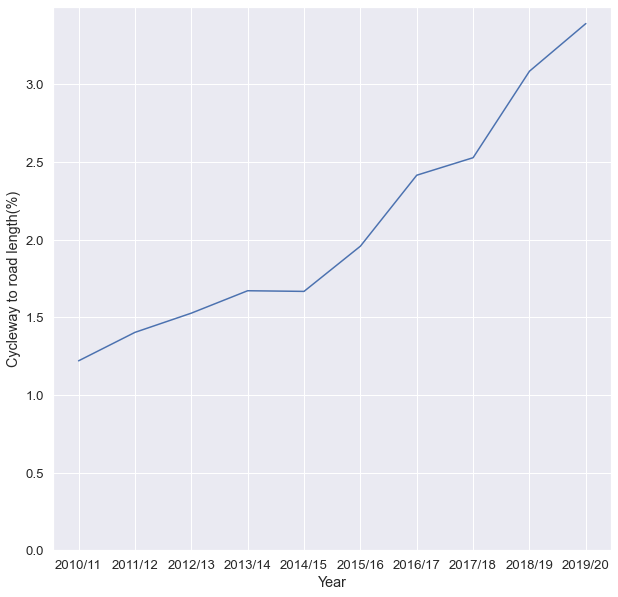

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(font_scale=1.15)
sns.lineplot(data=df_infrastructure.query("Area=='New Zealand'"), x="Year", y="Cycleway to road length(%)",
             hue='Area',style='Area',legend=False)
plt.ylim(0)
#df_cycleways.query("Type=='National'")
#ciint or “sd” or None

<h3>Travel section</h3>

In [15]:
sheet_names=['New Zealand','Northland','Auckland','Waikato','Bay of Plenty','Gisborne','Hawkes Bay',
       'Taranaki','Manawatu_Wanganui','Wellington','Nelson_Marlborough_Tasman','West Coast',
       'Canterbury','Otago','Southland']

df_travel=pd.DataFrame()

url_git = 'https://github.com/phtevegibson/data-projects/blob/main/datasets/Regions_travel-by-residents-2015_2018_revised.xlsx?raw=true'

for sheet in sheet_names:
    df_sheet = pd.read_excel(url_git,engine='openpyxl',sheet_name=sheet,header=9,nrows=8)
    df_sheet.insert(0,column='Area',value=sheet)
    
    df_travel=pd.concat([df_travel,df_sheet])
    
df_travel=df_travel.drop(columns=['Unnamed: 3','Unnamed: 7','Unnamed: 11','Unnamed: 15'])
    
print(df_travel.shape)
df_travel.head()

C:\Users\sgibs\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


(120, 13)


,Area,Mode of travel,Sample: People with any trips,Trip legs in sample,Million km per year,Million hours per year,Million trip legs per year,Mode share of distance,Mode share of duration,Mode share of trip legs,Km per person per year,Trip legs per person per year,Hours per person per year
0,New Zealand,1.Car/ van driver,5956,139005,32865,824.527,3750.68,0.645985,0.5810,0.5950,7003.73,799.292,175.712
1,New Zealand,2.Car/van passgr,4270,42479,13562.3,348.121,1509.85,0.266577,0.2453,0.2395,2890.21,321.757,74.1866
2,New Zealand,3.Pedestrian,3706,25493,666.451,143.241,751.22,0.013100,0.1009,0.1192,142.025,160.09,30.5255
3,New Zealand,4.Cyclist,435,2933,304.156,21.8782,82.3141,0.005978,0.0154,0.0131,64.8174,17.5416,4.66238
4,New Zealand,5.PT (bus/train/ferry),749,3953,1459.36,60.2115,157.68,0.028685,0.0424,0.0250,310.999,33.6025,12.8314


In [16]:
#rows to drop: pedestrians, PT, other household travel
columns_drop = ['Million km per year','Million hours per year','Million trip legs per year',
                'Mode share of distance','Mode share of duration','Mode share of trip legs',
                'Km per person per year','Trip legs per person per year','Hours per person per year']#,'Trip legs in sample'

df_travel_cycle = df_travel.drop(columns=columns_drop)

rows_mask=df_travel_cycle['Mode of travel'].isin(['Total'])
#'2.Car/van passgr','3.Pedestrian','5.PT (bus/train/ferry)','7.Other household travel',

df_travel_cycle=df_travel_cycle[~rows_mask]

df_travel_cycle.head()

,Area,Mode of travel,Sample: People with any trips,Trip legs in sample
0,New Zealand,1.Car/ van driver,5956,139005
1,New Zealand,2.Car/van passgr,4270,42479
2,New Zealand,3.Pedestrian,3706,25493
3,New Zealand,4.Cyclist,435,2933
4,New Zealand,5.PT (bus/train/ferry),749,3953


In [17]:
df_travel_motorised = df_travel_cycle.drop(df_travel_cycle[df_travel_cycle['Mode of travel']=='4.Cyclist'].index)
df_travel_motorised=df_travel_motorised.groupby(by=['Area']).sum()

#regional=regional.reset_index()
#print(regional.shape)
df_travel_motorised.head()

,Sample: People with any trips,Trip legs in sample
Area,,
Auckland,2812,37310
Bay of Plenty,1333,18618
Canterbury,1741,24059
Gisborne,359,6308
Hawkes Bay,596,8990


In [18]:
df_travel_only_cycle = df_travel_cycle.drop(df_travel_cycle[df_travel_cycle['Mode of travel']!='4.Cyclist'].index)
df_travel_only_cycle=df_travel_only_cycle.groupby(by=['Area']).sum()
df_travel_only_cycle.head()

,Sample: People with any trips,Trip legs in sample
Area,,
Auckland,44,323
Bay of Plenty,42,335
Canterbury,75,506
Gisborne,9,48
Hawkes Bay,23,176


In [19]:
df_cycle_ratio= df_travel_motorised.join(df_travel_only_cycle,lsuffix='_motor',rsuffix='_cycle')
df_cycle_ratio.head()

,Sample: People with any trips_motor,Trip legs in sample_motor,Sample: People with any trips_cycle,Trip legs in sample_cycle
Area,,,,
Auckland,2812,37310,44,323
Bay of Plenty,1333,18618,42,335
Canterbury,1741,24059,75,506
Gisborne,359,6308,9,48
Hawkes Bay,596,8990,23,176


In [20]:
df_cycle_ratio['people_%']=(df_cycle_ratio['Sample: People with any trips_cycle']/df_cycle_ratio['Sample: People with any trips_motor'])*100
df_cycle_ratio['trips_%']=(df_cycle_ratio['Trip legs in sample_cycle']/df_cycle_ratio['Trip legs in sample_motor'])*100
df_cycle_ratio.head()

,Sample: People with any trips_motor,Trip legs in sample_motor,Sample: People with any trips_cycle,Trip legs in sample_cycle,people_%,trips_%
Area,,,,,,
Auckland,2812,37310,44,323,1.564723,0.865720
Bay of Plenty,1333,18618,42,335,3.150788,1.799334
Canterbury,1741,24059,75,506,4.307869,2.103163
Gisborne,359,6308,9,48,2.506964,0.760938
Hawkes Bay,596,8990,23,176,3.859060,1.957731


In [21]:
df_cycle_ratio=df_cycle_ratio.reset_index()
df_cycle_ratio.head()

,Area,Sample: People with any trips_motor,Trip legs in sample_motor,Sample: People with any trips_cycle,Trip legs in sample_cycle,people_%,trips_%
0,Auckland,2812,37310,44,323,1.564723,0.865720
1,Bay of Plenty,1333,18618,42,335,3.150788,1.799334
2,Canterbury,1741,24059,75,506,4.307869,2.103163
3,Gisborne,359,6308,9,48,2.506964,0.760938
4,Hawkes Bay,596,8990,23,176,3.859060,1.957731


<h3>Combine cycleways and cycle trips data</h3>

In [22]:
df_cycle_ratio.Area.unique()

array(['Auckland', 'Bay of Plenty', 'Canterbury', 'Gisborne',
       'Hawkes Bay', 'Manawatu_Wanganui', 'Nelson_Marlborough_Tasman',
       'New Zealand', 'Northland', 'Otago', 'Southland', 'Taranaki',
       'Waikato', 'Wellington', 'West Coast'], dtype=object)

In [23]:
df_cycle_ratio = df_cycle_ratio.drop(df_cycle_ratio[df_cycle_ratio['Area']=='New Zealand'].index)

In [24]:
df_cycle_ratio.Area.unique()

array(['Auckland', 'Bay of Plenty', 'Canterbury', 'Gisborne',
       'Hawkes Bay', 'Manawatu_Wanganui', 'Nelson_Marlborough_Tasman',
       'Northland', 'Otago', 'Southland', 'Taranaki', 'Waikato',
       'Wellington', 'West Coast'], dtype=object)

In [25]:
df_cycle_ratio.at[5,'Area']='Manawatu-Whanganui'
df_cycle_ratio.at[6,'Area']='Marlborough-Nelson-Tasman'

In [26]:
df_cycle_ratio.Area.unique()

array(['Auckland', 'Bay of Plenty', 'Canterbury', 'Gisborne',
       'Hawkes Bay', 'Manawatu-Whanganui', 'Marlborough-Nelson-Tasman',
       'Northland', 'Otago', 'Southland', 'Taranaki', 'Waikato',
       'Wellington', 'West Coast'], dtype=object)

In [27]:
df_cycle_ratio.head()

,Area,Sample: People with any trips_motor,Trip legs in sample_motor,Sample: People with any trips_cycle,Trip legs in sample_cycle,people_%,trips_%
0,Auckland,2812,37310,44,323,1.564723,0.865720
1,Bay of Plenty,1333,18618,42,335,3.150788,1.799334
2,Canterbury,1741,24059,75,506,4.307869,2.103163
3,Gisborne,359,6308,9,48,2.506964,0.760938
4,Hawkes Bay,596,8990,23,176,3.859060,1.957731


In [28]:
df_infrastructure.head()

,Type,Area,Year,Cycleways(km),Roads(km),Cycleway to road length(%)
0,National,New Zealand,2010/11,1148.75,94201.100,1.219466
1,National,New Zealand,2011/12,1323.60,94367.683,1.402599
2,National,New Zealand,2012/13,1442.80,94530.000,1.526288
3,National,New Zealand,2013/14,1580.60,94614.800,1.670563
4,National,New Zealand,2014/15,1580.10,94822.200,1.666382


In [29]:
df_infrastructure.query("Type=='Regional'").Area.unique()
#df_infrastructure

array(['Auckland', 'Bay of Plenty', 'Canterbury', 'Gisborne',
       'Hawkes Bay', 'Manawatu-Whanganui', 'Marlborough-Nelson-Tasman',
       'Northland', 'Otago', 'Southland', 'Taranaki', 'Waikato',
       'Wellington', 'West Coast'], dtype=object)

In [30]:
df_infrastructure = df_infrastructure.query("Type=='Regional'")
df_infrastructure = df_infrastructure.drop(df_infrastructure[df_infrastructure['Year']!='2016/17'].index)

In [31]:
df_infrastructure

,Type,Area,Year,Cycleways(km),Roads(km),Cycleway to road length(%)
16,Regional,Auckland,2016/17,319.5,7753.0,4.120985
26,Regional,Bay of Plenty,2016/17,317.2,4651.4,6.819452
36,Regional,Canterbury,2016/17,484.4,15965.9,3.033966
46,Regional,Gisborne,2016/17,33.2,2220.3,1.495293
56,Regional,Hawkes Bay,2016/17,251.6,4665.9,5.392314
66,Regional,Manawatu-Whanganui,2016/17,117.4,8842.4,1.327694
76,Regional,Marlborough-Nelson-Tasman,2016/17,33.7,4253.0,0.792382
86,Regional,Northland,2016/17,23.4,6643.2,0.352240
96,Regional,Otago,2016/17,86.6,10507.4,0.824181
106,Regional,Southland,2016/17,90.2,7235.6,1.246614


In [32]:
df_cycle_ratio

,Area,Sample: People with any trips_motor,Trip legs in sample_motor,Sample: People with any trips_cycle,Trip legs in sample_cycle,people_%,trips_%
0,Auckland,2812,37310,44,323,1.564723,0.865720
1,Bay of Plenty,1333,18618,42,335,3.150788,1.799334
2,Canterbury,1741,24059,75,506,4.307869,2.103163
3,Gisborne,359,6308,9,48,2.506964,0.760938
4,Hawkes Bay,596,8990,23,176,3.859060,1.957731
5,Manawatu-Whanganui,815,11141,28,201,3.435583,1.804147
6,Marlborough-Nelson-Tasman,1025,16127,45,281,4.390244,1.742420
8,Northland,535,7665,16,70,2.990654,0.913242
9,Otago,1153,15568,27,92,2.341717,0.590956
10,Southland,610,9489,15,221,2.459016,2.329013


In [33]:
df_cycle_ratio['Cycleway to road length(%)']=df_infrastructure['Cycleway to road length(%)'].values

In [34]:
df_cycle_ratio

,Area,Sample: People with any trips_motor,Trip legs in sample_motor,Sample: People with any trips_cycle,Trip legs in sample_cycle,people_%,trips_%,Cycleway to road length(%)
0,Auckland,2812,37310,44,323,1.564723,0.865720,4.120985
1,Bay of Plenty,1333,18618,42,335,3.150788,1.799334,6.819452
2,Canterbury,1741,24059,75,506,4.307869,2.103163,3.033966
3,Gisborne,359,6308,9,48,2.506964,0.760938,1.495293
4,Hawkes Bay,596,8990,23,176,3.859060,1.957731,5.392314
5,Manawatu-Whanganui,815,11141,28,201,3.435583,1.804147,1.327694
6,Marlborough-Nelson-Tasman,1025,16127,45,281,4.390244,1.742420,0.792382
8,Northland,535,7665,16,70,2.990654,0.913242,0.352240
9,Otago,1153,15568,27,92,2.341717,0.590956,0.824181
10,Southland,610,9489,15,221,2.459016,2.329013,1.246614


(0.0, 4.531519966693265)

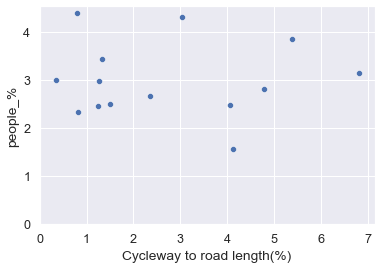

In [35]:
sns.scatterplot(data=df_cycle_ratio, x="Cycleway to road length(%)", y="people_%")
plt.xlim(0)
plt.ylim(0)

(0.0, 2.4159153775394393)

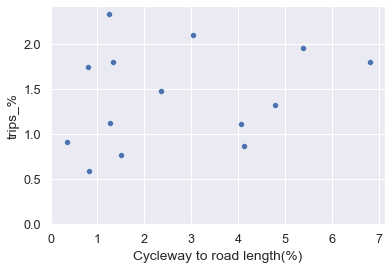

In [36]:
sns.scatterplot(data=df_cycle_ratio, x="Cycleway to road length(%)", y="trips_%")
plt.xlim(0)
plt.ylim(0)

(0.0, 2.4159153775394393)

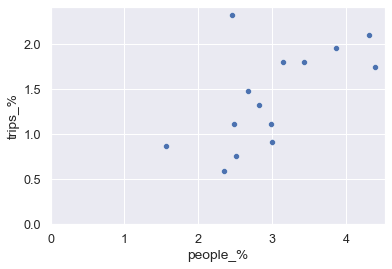

In [37]:
sns.scatterplot(data=df_cycle_ratio, x="people_%", y="trips_%")
plt.xlim(0)
plt.ylim(0)

Perentage of people who cycle - this is a measure of how attractive cycling is to everyone

Percentage of trips which are made by bicycle - this is a measure of how attractive it is to cycle regularly?